<a href="https://colab.research.google.com/github/ericttran3/Tutorials/blob/master/data_analytics/analyze_california_warn_report_edd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# California Worker Adjustment and Retraining Notification (WARN) 2024 Analysis

**Author:** Eric Tran

**Overview**

The Worker Adjustment and Retraining Notification (WARN) Act plays a crucial role in providing employees and their families with advance notice of layoffs and closures. This foresight is essential for effective preparation and planning. In this analysis, we will aggregate and analyze WARN data to uncover insights and trends that affect the US economy.

Our goal is to equip workers, researchers, and policymakers with timely and accessible data to enhance informed decision-making and strategic planning.

**Data Sources**

This analysis utilizes WARN reports, which detail layoffs and closures including their effective dates, the companies involved, and the number of employees affected. You can access the dataset used in this analysis here: [California Employment Development Department]("https://edd.ca.gov/en/jobs_and_training/layoff_services_warn").

| Key            | Value                                                          |
|:---------------|:---------------------------------------------------------------|
| County/Parish   | The county where the event occurred (e.g., Los Angeles County).|
| Notice Date     | The date the notice was filed.                                 |
| Processed Date  | The date the notice was processed.                             |
| Effective Date  | The date when the layoff or closure becomes effective.         |
| Company        | The name of the company conducting layoffs or closures.        |
| Layoff/Closure  | Indicates whether the event is a layoff or closure and if it's permanent.|
| No. Of Employees  | The number of employees affected.                             |
| Address        | The address of the affected location.                         |


**Today we'll cover**

1. **Data Overview:** A comprehensive analysis using summary statistics to understand the breadth of the data.
2. **Geographic Trends:** Examination of how layoffs and closures are distributed across different regions and over time.
3. **Impact Visualization:** Visual representation of the impacts across various sectors and locations.

**Expected Outcomes**

By the end of this analysis, you'll gain a deeper understanding of the scale and scope of layoffs and closures. We'll identify major trends and highlight the types of layoffs that are most prevalent, providing valuable insights into the dynamics of the job market.

##### Import Libraries

In [2]:
# Install necessary packages
!pip install altair geopandas contextily gspread google-auth --quiet

# Import packages
from google.colab import drive, auth, userdata
from google.auth import default
from google.oauth2.service_account import Credentials
from google.oauth2 import service_account
from googleapiclient.discovery import build
import gspread
import os
import re
import datetime as dt
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import geopandas as gpd
import contextily as ctx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 13.3 MB/s eta 0:00:00


##### Configure Enviornment

In [23]:
# Today's date
today = pd.to_datetime("today").date()
current_timestamp = dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Today's date: {today}")
print("Current Timestamp:", current_timestamp)

# GCP credentials
gcp_creds = userdata.get('GCP_CREDS_FILE_PATH')

# Mount drive
drive.mount('/content/drive')

Today's date: 2024-07-21
Current Timestamp: 2024-07-21 01:04:18
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
# Load the service account key file
with open(gcp_creds) as source:
    info = json.load(source)
credentials = service_account.Credentials.from_service_account_info(info)

# Create a Google Drive API client
drive_service = build('drive', 'v3', credentials=credentials)

# Example: List files in the shared folder
results = drive_service.files().list(pageSize=10).execute()
items = results.get('files', [])

if not items:
    print('No files found.')
else:
    print('Files:')
    for item in items:
        print(f"{item['name']} ({item['id']})")

Files:
analyze_california_warn_report_edd.ipynb (1w_NspqNYOQhNwgETU2ae-kYPs2b-_lAV)
Colab Notebooks (1XS7BqPopOhCl2gvC6qAZ66FT_ZLibvb2)
beautifulsoup.ipynb (1HGTVbmT7nL_rDM_vkWbNsbWFA9MU9A2C)
request.ipynb (119R9O18Tl9UChYjXHhgmyDbae-euVy9v)
datetime.ipynb (1RMA90C-nRdWjmGoaQsA_URO9D0pz7OcL)
aws.ipynb (1TsShY0iXXRYGZoD4wGnAj4dCKVOS_Saa)
california_warn_report_history (1jyChApq_ByLxzl5R3owI1retuRSmcfN01msh0iRwLjc)
california_warn_report_latest (1aRyRVvn3xSrIknw_djOK9XUyfMDVqEuvEDRk68bL4UY)
get_data_table_from_pdf_files_pdfplumber.ipynb (1fcXc8GS-k8MmaskJ90NV0qQRN60T0Ma9)
california-warn-historical-2024-07-11.csv (1-0Ftw8Wkpj3D0-MCPMNI6W5lam0lmGap)


##### Functions

In [19]:
def get_data(url, sheet_name=2, header=1):
    """
    Function to read a Excel file and process the data.

    Args:
    filepath (str): The path to the Excel file.

    Returns:
    pd.DataFrame: The processed DataFrame.
    """
    # Load the Excel file into a DataFrame
    df = pd.read_excel(url, sheet_name=2, header=1)

    # Remove unwanted characters from column headers
    df.columns = df.columns.str.replace('\n|\.| |/|Parish', '', regex=True)

    # Rename columns
    df.rename(
        columns={
            'ProcessedDate': 'ReceivedDate',
            'LayoffClosure': 'LayoffClosureType'
            },
        inplace=True
        )

    # Fill in Nulls for 'City'
    df['City'] = ''

    # Call format_data function to convert data types and handle other formatting
    df = format_data(parse_address(df))

    return df

def get_historical_data(file_name):
    """
    Function to read a CSV file and process the data.

    Args:
    file_name (str): The name of the CSV file.

    Returns:
    pd.DataFrame: The processed DataFrame.
    """

    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_name)

    df = format_data(parse_address(df))

    return df

def format_data(df):
    # Convert date columns to datetime format
    date_columns = ['NoticeDate', 'ReceivedDate', 'EffectiveDate']
    df[date_columns] = df[date_columns].apply(pd.to_datetime, errors='coerce')

    # Normalize and map 'LayoffClosureType' values
    mapping = {
        'Layoff Permanent': 'Layoff Permanent',
        'Layoff Temporary': 'Layoff Temporary',
        'Closure Permanent': 'Closure Permanent',
        'Closure Temporary': 'Closure Temporary'
    }
    df['LayoffClosureType'] = df['LayoffClosureType'].map(mapping).fillna('Unknown')

    # Convert 'LayoffClosureType', 'StateCode', and 'PostalCode' to categorical data type
    categorical_columns = ['LayoffClosureType', 'StateCode', 'PostalCode', 'City', 'County']
    df[categorical_columns] = df[categorical_columns].astype('category')

    # # Ensuring numeric fields are treated correctly
    if 'NoOfEmployees' in df.columns:
        df['NoOfEmployees'] = df['NoOfEmployees'].astype('Int64')

    # Ensuring columns exist before filtering them
    columns = ['NoticeDate', 'ReceivedDate', 'EffectiveDate', 'Company', 'Address', 'City', 'County', 'StateCode', 'PostalCode', 'NoOfEmployees', 'LayoffClosureType']
    columns = [col for col in columns if col in df.columns]
    df = df[columns]

    # Sort by EffectiveDate
    df.sort_values(by=['ReceivedDate'], ascending=False, inplace=True)

    # Add timestamp data updated at
    df['UpdatedAt'] = current_timestamp

    return df

def unify_dataframes(dataframes):
    """
    Unifies multiple DataFrames into a single DataFrame with a common set of columns.

    Args:
        dataframes (list of DataFrame): List of DataFrames to be unified.

    Returns:
        DataFrame: A single unified DataFrame.
    """

    all_columns = ['NoticeDate', 'ReceivedDate', 'EffectiveDate', 'Company', 'Address', 'City', 'County', 'StateCode', 'PostalCode', 'NoOfEmployees', 'LayoffClosureType', 'UpdatedAt']
    unified_dfs = [df.reindex(columns=all_columns, fill_value='') for df in dataframes]
    final_df = pd.concat(unified_dfs, ignore_index=True)
    return final_df

def parse_address(df):
    # Updated pattern to extract city, state code, and postal code
    pattern = re.compile(r"""
    \b                          # Word boundary to ensure matching starts at a break
    (?:\d+\s+)?                 # Optionally match leading street number
    (?:[A-Za-z0-9\s,]+)         # Optionally match street name
    (?:Street|St\.?|Avenue|Ave\.?|Road|Rd\.?|Boulevard|Blvd\.?|Drive|Dr\.?|Lane|Ln\.?|Court|Ct\.?|Circle|Cir\.?|Ext\.?|West|East|North|South|Main|Chester|Eckhoff|Place|Pl\.?|Parkway|Pkwy|STE\.?|Suite|Suite\s[A-Za-z0-9]+)? # Street types
    \s*,?\s+                    # One or more spaces or a comma before city name
    (?:[NESWH]\.?\s+)?          # Optionally match directional prefixes like N., S., E., W.
    ([A-Za-z\s]+?)              # City name (more robust pattern might be needed for complex names)
    \s+                         # Space before state code
    ([A-Z]{2})                  # State code
    \s+                         # Space before zip code
    (\d{5})                     # Postal code
    \b                          # Word boundary to ensure matching ends at a break
    """, re.VERBOSE)

    # Lists to hold the parsed data
    cities = []
    state_codes = []
    postal_codes = []

    # Iterate over each entry in the Address column
    for address in df['Address']:
        if pd.notna(address):
            match = pattern.search(str(address))  # Convert address to string to avoid TypeError
            if match:
                cities.append(match.group(1).strip())       # City name
                state_codes.append(match.group(2).strip())  # State code
                postal_codes.append(match.group(3).strip()) # Postal code
            else:
                # Append empty strings if no match is found
                cities.append('')
                state_codes.append('')
                postal_codes.append('')
        else:
            # Append empty strings if the address is NaN
            cities.append('')
            state_codes.append('')
            postal_codes.append('')

    # Assign the extracted data to new columns in the DataFrame
    df['City'] = cities
    df['StateCode'] = state_codes
    df['PostalCode'] = postal_codes

    return df

def df_to_google_sheets(df, sheet_title, creds_json):
    """
    Saves a pandas DataFrame to a Google Sheet.

    Args:
        df (pd.DataFrame): DataFrame to be saved.
        sheet_title (str): Title of the Google Sheet to create or update.
        creds_json (str): Path to the JSON credentials file for Google API.

    Returns:
        str: URL of the Google Sheet.
    """

    # Convert any Timestamp objects to strings
    df = df.astype(str)

    # Authenticate using service account
    scope = ['https://www.googleapis.com/auth/spreadsheets', 'https://www.googleapis.com/auth/drive']
    creds = Credentials.from_service_account_file(creds_json, scopes=scope)
    client = gspread.authorize(creds)

    try:
        # Try to open the spreadsheet if it exists
        spreadsheet = client.open(sheet_title)
    except gspread.SpreadsheetNotFound:
        # Create the spreadsheet if it does not exist
        spreadsheet = client.create(sheet_title)
        # If you need to share the sheet with your email
        client.insert_permission(
            spreadsheet.id,
            None,  # None will default to your email from the service account
            perm_type='user',
            role='writer'
        )

    # Select the first sheet
    worksheet = spreadsheet.sheet1
    worksheet.clear()  # Clear existing content

    # Get the DataFrame data in a list of lists format, including headers
    values = [df.columns.tolist()] + df.values.tolist()

    # Update the Google Sheet with the DataFrame data
    worksheet.update(values, 'A1')

    return spreadsheet.url

In [20]:
url = "https://edd.ca.gov/siteassets/files/jobs_and_training/warn/warn_report1.xlsx"
current_df = get_data(url)

In [21]:
current_df

,NoticeDate,ReceivedDate,EffectiveDate,Company,Address,City,County,StateCode,PostalCode,NoOfEmployees,LayoffClosureType,UpdatedAt
27,2024-07-17,2024-07-17,2024-08-31,"Warner Bros. Discovery, Inc.",100 S. California Street Burbank CA 91505,California Street Burbank,Los Angeles County,CA,91505,270,Layoff Permanent,2024-07-21 01:02:56
26,2024-07-17,2024-07-17,2024-10-01,"Southwire Company, LLC","9199 Cleveland Avenue, Suite 100 Rancho Cucam...",Cucamonga,San Bernardino County,CA,91730,95,Closure Permanent,2024-07-21 01:02:56
25,2024-07-16,2024-07-17,2024-09-16,"Exabeam, Inc.",1051 E Hillsdale Blvd 4th Floor Foster City C...,City,San Mateo County,CA,94404,43,Layoff Permanent,2024-07-21 01:02:56
24,2024-07-11,2024-07-16,2024-09-09,UKG Inc.,55 2nd St Suite #2300 San Francisco CA 94105,Francisco,San Francisco County,CA,94105,12,Layoff Permanent,2024-07-21 01:02:56
23,2024-07-11,2024-07-16,2024-09-09,UKG Inc.,5 Hutton Centre Dr # 1100 Santa Ana CA 92707,Ana,Orange County,CA,92707,195,Layoff Permanent,2024-07-21 01:02:56
22,2024-07-15,2024-07-16,2024-09-13,"Rodan & Fields, LLC","3001 Bishop Drive, Suite 450 San Ramon CA 94583",Ramon,Contra Costa County,CA,94583,78,Layoff Permanent,2024-07-21 01:02:56
21,2024-07-15,2024-07-15,2024-09-13,City National Bank,555 S. Flower Street Los Angeles CA 90012,Flower Street Los Angeles,Los Angeles County,CA,90012,2,Layoff Permanent,2024-07-21 01:02:56
20,2024-07-15,2024-07-15,2024-09-13,City National Bank,350 S. Grand Avenue Los Angeles CA 90003,Grand Avenue Los Angeles,Los Angeles County,CA,90003,6,Layoff Permanent,2024-07-21 01:02:56
19,2024-07-12,2024-07-12,2024-09-10,"TuSimple, Inc.",9191 Towne Centre Drive San Diego CA 92122,Diego,San Diego County,CA,92122,1,Layoff Permanent,2024-07-21 01:02:56
18,2024-07-11,2024-07-11,2024-09-14,"US Foods, Inc.",1201 Park Center Drive Vista CA 92081,Vista,San Diego County,CA,92081,97,Layoff Permanent,2024-07-21 01:02:56


In [22]:
current_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28 entries, 27 to 0
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   NoticeDate         28 non-null     datetime64[ns]
 1   ReceivedDate       28 non-null     datetime64[ns]
 2   EffectiveDate      28 non-null     datetime64[ns]
 3   Company            28 non-null     object        
 4   Address            28 non-null     object        
 5   City               28 non-null     category      
 6   County             28 non-null     category      
 7   StateCode          28 non-null     category      
 8   PostalCode         28 non-null     category      
 9   NoOfEmployees      28 non-null     Int64         
 10  LayoffClosureType  28 non-null     category      
 11  UpdatedAt          28 non-null     object        
dtypes: Int64(1), category(5), datetime64[ns](3), object(3)
memory usage: 5.6+ KB


In [8]:
historical_df = get_historical_data('/content/drive/MyDrive/Colab Notebooks/Data/california-warn-historical-2024-07-11.csv')

In [9]:
historical_df.head()

,NoticeDate,ReceivedDate,EffectiveDate,Company,Address,City,County,StateCode,PostalCode,NoOfEmployees,LayoffClosureType,UpdatedAt
1746,2024-06-28,2024-06-28,2024-08-30,Kohana Coffee Company,514 West Ohio Avenue Richmond CA 94804,Richmond,Contra Costa County,CA,94804,51,Closure Permanent,2024-07-14 20:57:22
1749,2024-06-20,2024-06-28,2024-08-20,CI Manufacturing Facility,"8825 Elder Creek Road, Suite 600 Sacramento CA...",Sacramento,Sacramento County,CA,95828,153,Layoff Temporary,2024-07-14 20:57:22
1748,2024-06-20,2024-06-28,2024-08-20,CI Office,"10630 Mather Blvd, Suite 200 Mather CA 95655",Mather,Sacramento County,CA,95655,12,Layoff Temporary,2024-07-14 20:57:22
1747,2024-06-28,2024-06-28,2024-08-30,Firebaugh Facility of Olam Americas,4761 West Nees Avenue Firebaugh CA 93622,Firebaugh,Fresno County,CA,93622,275,Closure Permanent,2024-07-14 20:57:22
1745,2024-06-27,2024-06-27,2024-08-29,Lockheed Martin Space,1111 Lockheed Martin Way Sunnyvale CA 94089,Sunnyvale,Santa Clara County,CA,94089,68,Layoff Permanent,2024-07-14 20:57:22


In [10]:
historical_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13583 entries, 1746 to 12832
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   NoticeDate         13583 non-null  datetime64[ns]
 1   ReceivedDate       13583 non-null  datetime64[ns]
 2   EffectiveDate      13580 non-null  datetime64[ns]
 3   Company            13583 non-null  object        
 4   Address            3699 non-null   object        
 5   City               13583 non-null  category      
 6   County             11486 non-null  category      
 7   StateCode          13583 non-null  category      
 8   PostalCode         13583 non-null  category      
 9   NoOfEmployees      13581 non-null  Int64         
 10  LayoffClosureType  13583 non-null  category      
 11  UpdatedAt          13583 non-null  object        
dtypes: Int64(1), category(5), datetime64[ns](3), object(3)
memory usage: 1.5+ MB


#### Combine Dataframes

In [11]:
dfs = [current_df, historical_df]
combined_df = unify_dataframes(dfs)

In [12]:
combined_df.head(25)

,NoticeDate,ReceivedDate,EffectiveDate,Company,Address,City,County,StateCode,PostalCode,NoOfEmployees,LayoffClosureType,UpdatedAt
0,2024-07-10,2024-07-10,2024-09-09,Intuit Inc.,2700 Coast Ave. Mountain View CA 94043,Mountain View,Santa Clara County,CA,94043,384,Layoff Permanent,2024-07-14 20:57:22
1,2024-07-09,2024-07-10,2024-09-06,"Hybrid Promotions, LLC dba Hybrid Apparel",6060 Business Center Ct San Diego CA 92154,Diego,San Diego County,CA,92154,22,Closure Permanent,2024-07-14 20:57:22
2,2024-07-10,2024-07-10,2024-09-09,Intuit Inc.,7535 Torrey Santa Fe Rd San Diego CA 92129,Diego,San Diego County,CA,92129,215,Layoff Permanent,2024-07-14 20:57:22
3,2024-07-08,2024-07-08,2024-09-06,"Hybrid Promotions, LLC dba Hybrid Apparel",5701 Skylab Drive Huntington Beach CA 92647,Beach,Orange County,CA,92647,24,Layoff Temporary,2024-07-14 20:57:22
4,2024-07-05,2024-07-08,2024-09-06,Novartis Pharmaceuticals Corporation,10210 Campus Point Dr. #350 San Diego CA 92121,Diego,San Diego County,CA,92121,29,Closure Permanent,2024-07-14 20:57:22
5,2024-07-01,2024-07-03,2024-08-31,Western Specialty Contractors,1501 Wicks Blvd San Leandro CA 94577,Leandro,Alameda County,CA,94577,8,Closure Permanent,2024-07-14 20:57:22
6,2024-07-03,2024-07-03,2024-09-05,"F&E Aircraft Maintenance dba FEAM Aero, LLC",1490 S. Vineyard Ave Ste D Ontario CA 91761,Vineyard Ave Ste D Ontario,San Bernardino County,CA,91761,26,Layoff Permanent,2024-07-14 20:57:22
7,2024-07-02,2024-07-03,2024-09-01,"Refratechnik North America, Inc.",14549 Manzanita Dr. Fontana CA 92335,Fontana,San Bernardino County,CA,92335,8,Closure Permanent,2024-07-14 20:57:22
8,2024-06-27,2024-07-03,2024-06-27,"Motorcar Parts of America, Inc.",2929 California Street Torrance CA 90503,Torrance,Los Angeles County,CA,90503,94,Layoff Permanent,2024-07-14 20:57:22
9,2024-07-02,2024-07-02,2024-09-01,Cargill Meat Solutions Corporation,3115 South Fig Avenue Fresno CA 93706,Fresno,Fresno County,CA,93706,20,Layoff Permanent,2024-07-14 20:57:22


In [16]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13599 entries, 0 to 13598
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   NoticeDate         13599 non-null  datetime64[ns]
 1   ReceivedDate       13599 non-null  datetime64[ns]
 2   EffectiveDate      13596 non-null  datetime64[ns]
 3   Company            13599 non-null  object        
 4   Address            3715 non-null   object        
 5   City               13599 non-null  object        
 6   County             11502 non-null  object        
 7   StateCode          13599 non-null  object        
 8   PostalCode         13599 non-null  object        
 9   NoOfEmployees      13597 non-null  Int64         
 10  LayoffClosureType  13599 non-null  object        
 11  UpdatedAt          13599 non-null  object        
dtypes: Int64(1), datetime64[ns](3), object(8)
memory usage: 1.3+ MB


In [17]:
# Save copy of processed file
# combined_df.to_csv(f'/content/drive/My Drive/Colab Notebooks/Data/california-warn-report-historical-{today}.csv', index=False)

# Save most recent processed file
# current_df.to_csv(f'/content/drive/My Drive/Colab Notebooks/Data/california-warn-report-latest-{today}.csv', index=False)
# combined_df.to_csv(f'/content/drive/My Drive/Colab Notebooks/Data/california-warn-report-historical-{today}.csv', index=False)

# Save most recent processed file to Google Sheets
df_to_google_sheets(current_df, 'california_warn_report_latest', gcp_creds)
# Save most recent processed file to Google Sheets
df_to_google_sheets(combined_df, 'california_warn_report_history', gcp_creds)

'https://docs.google.com/spreadsheets/d/1jyChApq_ByLxzl5R3owI1retuRSmcfN01msh0iRwLjc'

##### EDA

In [18]:
df = combined_df
descriptive_stats = df.describe()
descriptive_stats

,NoticeDate,ReceivedDate,EffectiveDate,NoOfEmployees
count,13599,13599,13596,13597.0
mean,2020-04-19 23:11:30.138980608,2020-05-11 15:53:00.675049728,2020-05-26 14:01:54.386584320,88.035817
min,2008-09-04 00:00:00,2014-07-01 00:00:00,2002-07-04 00:00:00,1.0
25%,2019-04-26 00:00:00,2019-05-03 00:00:00,2019-06-30 00:00:00,14.0
50%,2020-04-10 00:00:00,2020-05-15 00:00:00,2020-04-03 00:00:00,52.0
75%,2021-12-22 00:00:00,2021-12-31 00:00:00,2022-03-02 00:00:00,98.0
max,2024-07-10 00:00:00,2024-07-10 00:00:00,2121-03-09 00:00:00,6912.0
std,NaN,NaN,NaN,167.775988


In [21]:
# Summary Statistics for Number of Employees Affected
employees_stats = df['NoOfEmployees'].describe()
print("Summary Statistics for Number of Employees Affected")
print(f"- Count: {employees_stats['count']} recorded instances of layoffs or closures.")
print(f"- Mean: On average, each instance affected about {employees_stats['mean']:.0f} employees.")
print(f"- Standard Deviation: The standard deviation is approximately {employees_stats['std']:.0f}, indicating a wide variation.")
print(f"- Minimum: The smallest layoff/closure affected only {employees_stats['min']:.0f} employee.")
print(f"- 25th Percentile: 25% of the instances affected {employees_stats['25%']:.0f} or fewer employees.")
print(f"- Median: The median number of affected employees is {employees_stats['50%']:.0f}.")
print(f"- 75th Percentile: 75% of the instances affected {employees_stats['75%']:.0f} or fewer employees.")
print(f"- Maximum: The largest instance affected {employees_stats['max']:.0f} employees.")

# Distribution Across Categories
print("\nDistribution Across Categories")
print(f"- Counties/Parishes Reported: The dataset includes instances from {df['County'].nunique()} different counties or parishes.")
print(f"- Unique Notice Dates: There are {df['NoticeDate'].nunique()} unique notice dates.")
print(f"- Processed Dates: The data includes {df['ReceivedDate'].nunique()} unique processed dates.")
print(f"- Effective Dates: There are {df['EffectiveDate'].nunique()} unique effective dates for layoffs and closures.")
print(f"- Unique Companies: {df['Company'].nunique()} different companies have reported layoffs or closures.")
types_counts = df['LayoffClosureType'].value_counts()
print(f"- Types of Layoff/Closure: The dataset distinguishes between {types_counts.count()} types of layoffs/closures.")
for type, count in types_counts.items():
    print(f"  - {type}: {count} instances")
print(f"- Unique Addresses: There are {df['Address'].nunique()} unique addresses listed, highlighting the geographic diversity.")

# Insights
print("\nInsights")
print("- The dataset shows a significant number of permanent layoffs, significantly outnumbering temporary layoffs and closures.")
print("- There's a considerable variation in the impact of these layoffs/closures, with some affecting a small number of employees and others affecting large groups.")
print("- The wide range of effective dates and the diversity of companies involved suggest that layoffs and closures are widespread across different sectors and times, indicating no concentration in a specific period within the data's range.")

Summary Statistics for Number of Employees Affected
- Count: 13597.0 recorded instances of layoffs or closures.
- Mean: On average, each instance affected about 88 employees.
- Standard Deviation: The standard deviation is approximately 168, indicating a wide variation.
- Minimum: The smallest layoff/closure affected only 1 employee.
- 25th Percentile: 25% of the instances affected 14 or fewer employees.
- Median: The median number of affected employees is 52.
- 75th Percentile: 75% of the instances affected 98 or fewer employees.
- Maximum: The largest instance affected 6912 employees.

Distribution Across Categories
- Counties/Parishes Reported: The dataset includes instances from 63 different counties or parishes.
- Unique Notice Dates: There are 2244 unique notice dates.
- Processed Dates: The data includes 2020 unique processed dates.
- Effective Dates: There are 2394 unique effective dates for layoffs and closures.
- Unique Companies: 8469 different companies have reported layoff

##### Data Visualization

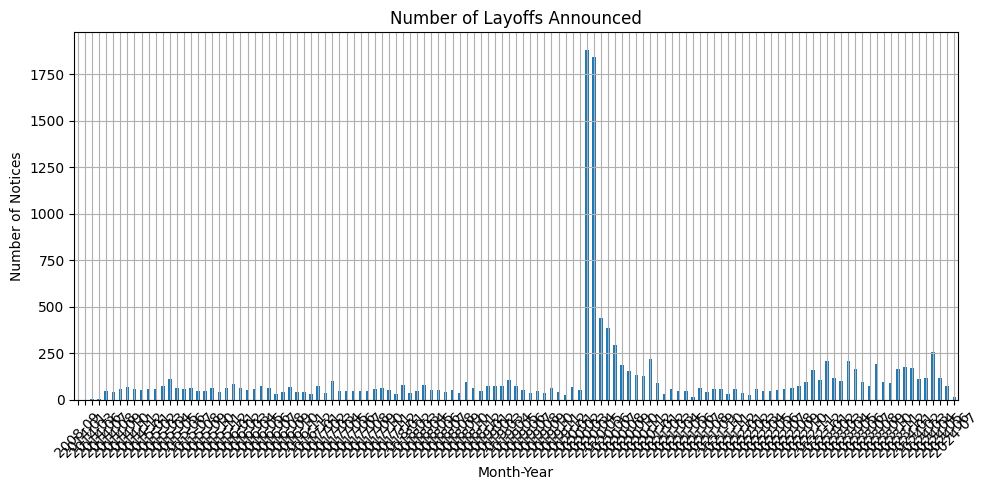

In [22]:
# Assuming df['NoticeDate'] is already a datetime object, creating a month-year column from NoticeDate for grouping
df['MonthYear'] = df['NoticeDate'].dt.to_period('M')

# Counting the number of notices per month
monthly_trends = df.groupby('MonthYear').size()

# Plotting the monthly trends as a bar chart
plt.figure(figsize=(10, 5))
monthly_trends.plot(kind='bar')
plt.title('Number of Layoffs Announced')
plt.xlabel('Month-Year')
plt.ylabel('Number of Notices')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

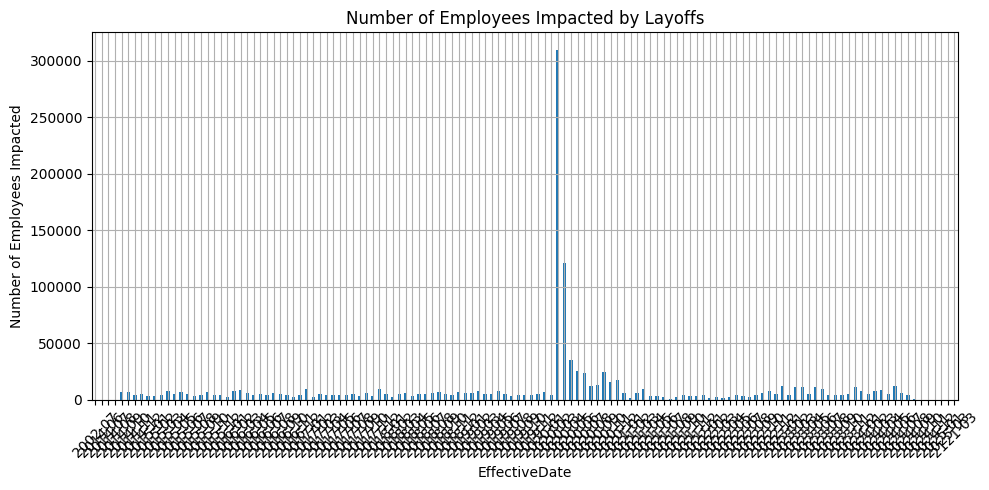

In [23]:
# Group by MonthYear and sum NoOfEmployees
monthly_layoffs = df.groupby(df['EffectiveDate'].dt.to_period("M"))['NoOfEmployees'].sum()

# Plotting the data
plt.figure(figsize=(10, 5))
monthly_layoffs.plot(kind='bar')
plt.title('Number of Employees Impacted by Layoffs')
plt.ylabel('Number of Employees Impacted')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

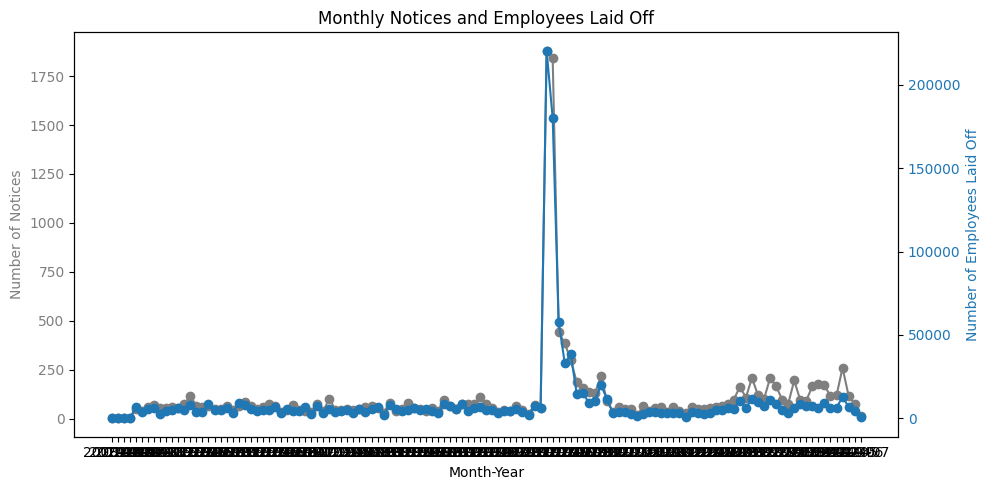

In [24]:
# Group df by month and calculate the sum and count
monthly_df = df.groupby(df['NoticeDate'].dt.to_period("M")).agg(
    Notices=('NoticeDate', 'size'),
    Employees_Laid_Off=('NoOfEmployees', 'sum')
)

# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 5))  # Adjust the figure size here

# Plot number of notices
color = 'tab:grey'
ax1.set_xlabel('Month-Year')
ax1.set_ylabel('Number of Notices', color=color)
ax1.plot(monthly_df.index.astype(str), monthly_df['Notices'], color=color, marker='o', linestyle='-')
ax1.tick_params(axis='y', labelcolor=color)

# Create a twin of the first axis to share the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Number of Employees Laid Off', color=color)
ax2.plot(monthly_df.index.astype(str), monthly_df['Employees_Laid_Off'], color=color, marker='o', linestyle='-')
ax2.tick_params(axis='y', labelcolor=color)

# Show the plot
plt.title('Monthly Notices and Employees Laid Off')
fig.tight_layout()  # Adjust layout to make room for the second y-axis
plt.xticks(rotation=45)
plt.show()

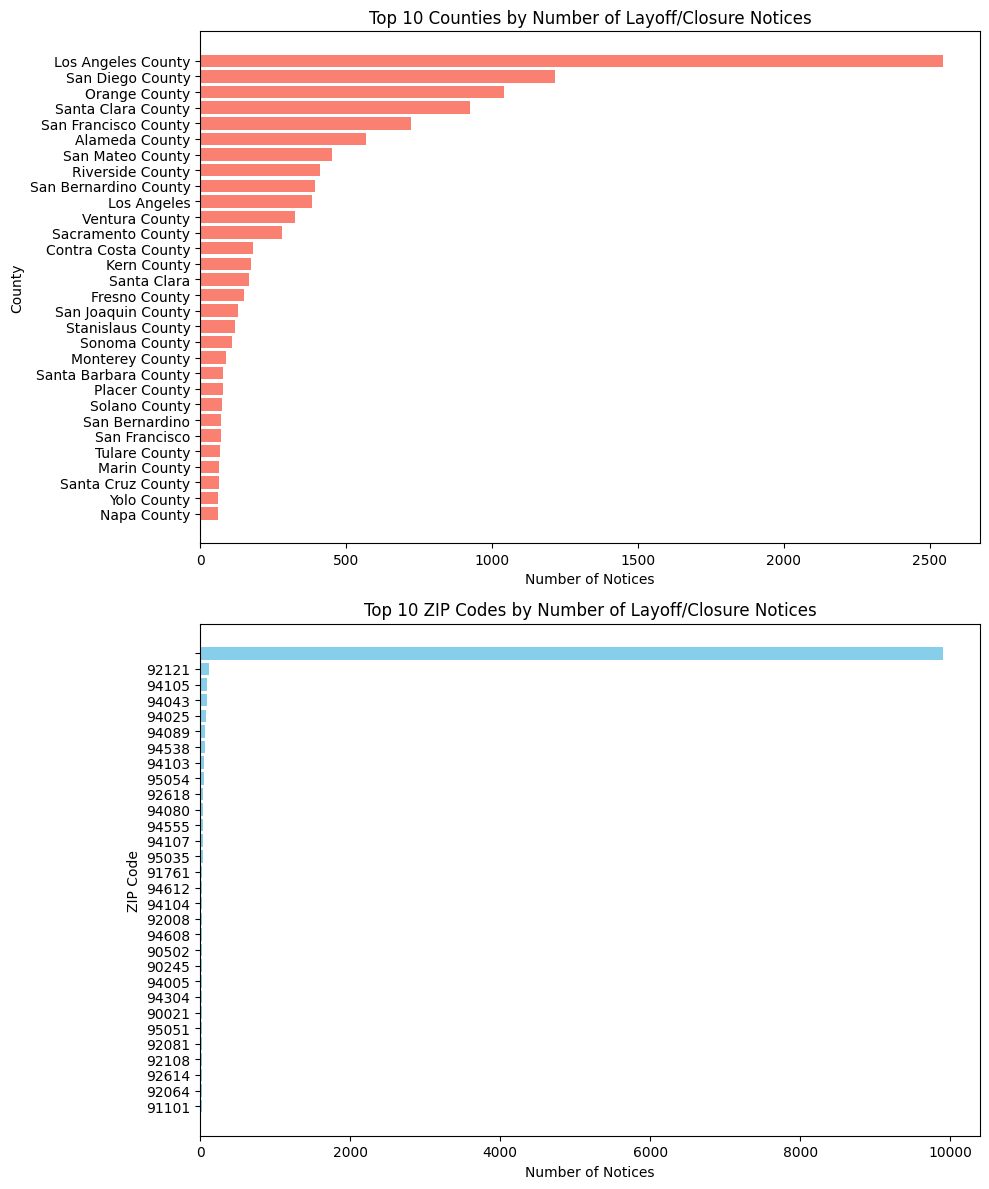

In [25]:
# Frequency of layoffs/closures per ZIP code
zip_code_counts = df['PostalCode'].value_counts().head(30)  # Top 10 ZIP codes
zip_code_counts_sorted = zip_code_counts.sort_values(ascending=True)  # Sort for horizontal bar chart

# Frequency of layoffs/closures per county
county_counts = df['County'].value_counts().head(30)
county_counts_sorted = county_counts.sort_values(ascending=True)

# Plotting the results
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Plot for counties
ax[0].barh(county_counts_sorted.index, county_counts_sorted.values, color='salmon')
ax[0].set_title('Top 10 Counties by Number of Layoff/Closure Notices')
ax[0].set_xlabel('Number of Notices')
ax[0].set_ylabel('County')

# Plot for ZIP codes
ax[1].barh(zip_code_counts_sorted.index, zip_code_counts_sorted.values, color='skyblue')
ax[1].set_title('Top 10 ZIP Codes by Number of Layoff/Closure Notices')
ax[1].set_xlabel('Number of Notices')
ax[1].set_ylabel('ZIP Code')

plt.tight_layout()
plt.show()

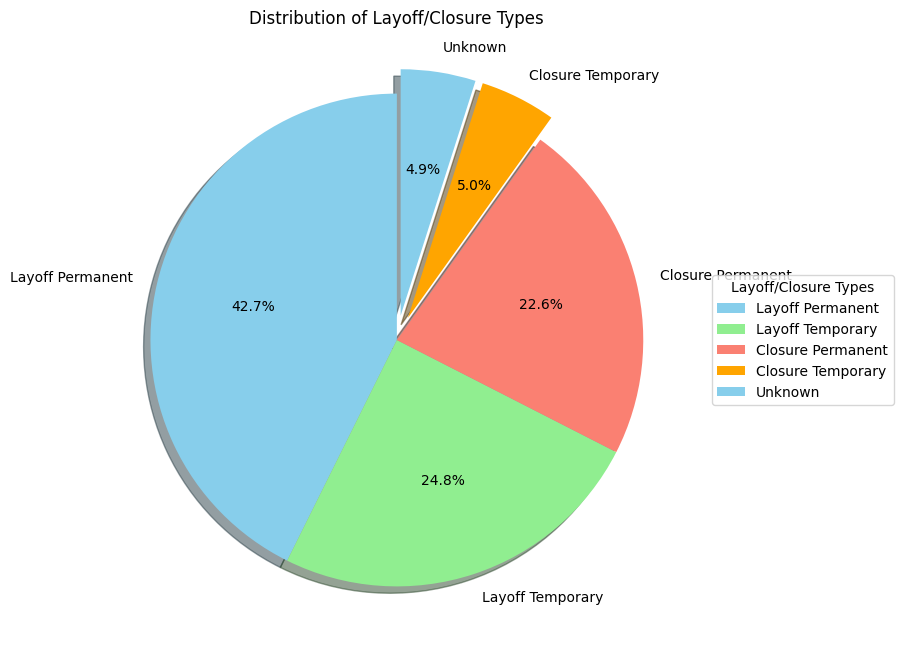

In [26]:
# Count of each layoff/closure type
layoff_closure_distribution = df['LayoffClosureType'].value_counts()

# Determine 'explode' to separate smaller slices
explode = [0.1 if val < sum(layoff_closure_distribution) * 0.1 else 0 for val in layoff_closure_distribution]

# Plotting the distribution
plt.figure(figsize=(10, 8))  # Increased figure size
layoff_closure_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=90, explode=explode, shadow=True, colors=['skyblue', 'lightgreen', 'salmon', 'orange'])
plt.title('Distribution of Layoff/Closure Types')
plt.ylabel('')  # Hide the y-label as it's not needed for pie charts
plt.legend(labels=layoff_closure_distribution.index, title="Layoff/Closure Types", loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

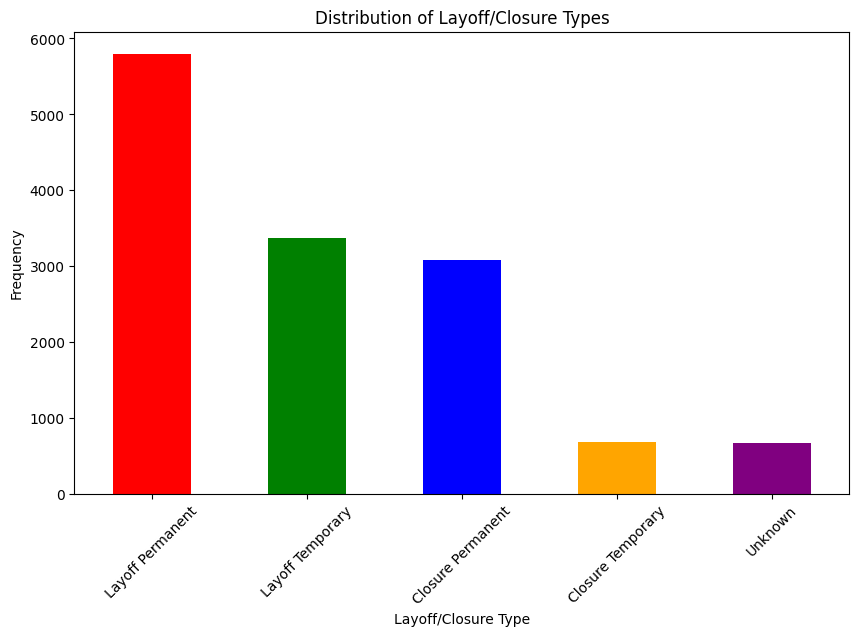

In [27]:
# Count of each layoff/closure type
layoff_closure_distribution = df['LayoffClosureType'].value_counts()

# Define a list of colors
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta']

# Plotting the distribution as a vertical bar chart
plt.figure(figsize=(10, 6))
layoff_closure_distribution.plot(kind='bar', color=colors[:len(layoff_closure_distribution)])
plt.title('Distribution of Layoff/Closure Types')
plt.xlabel('Layoff/Closure Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate labels to avoid overlap
plt.show()

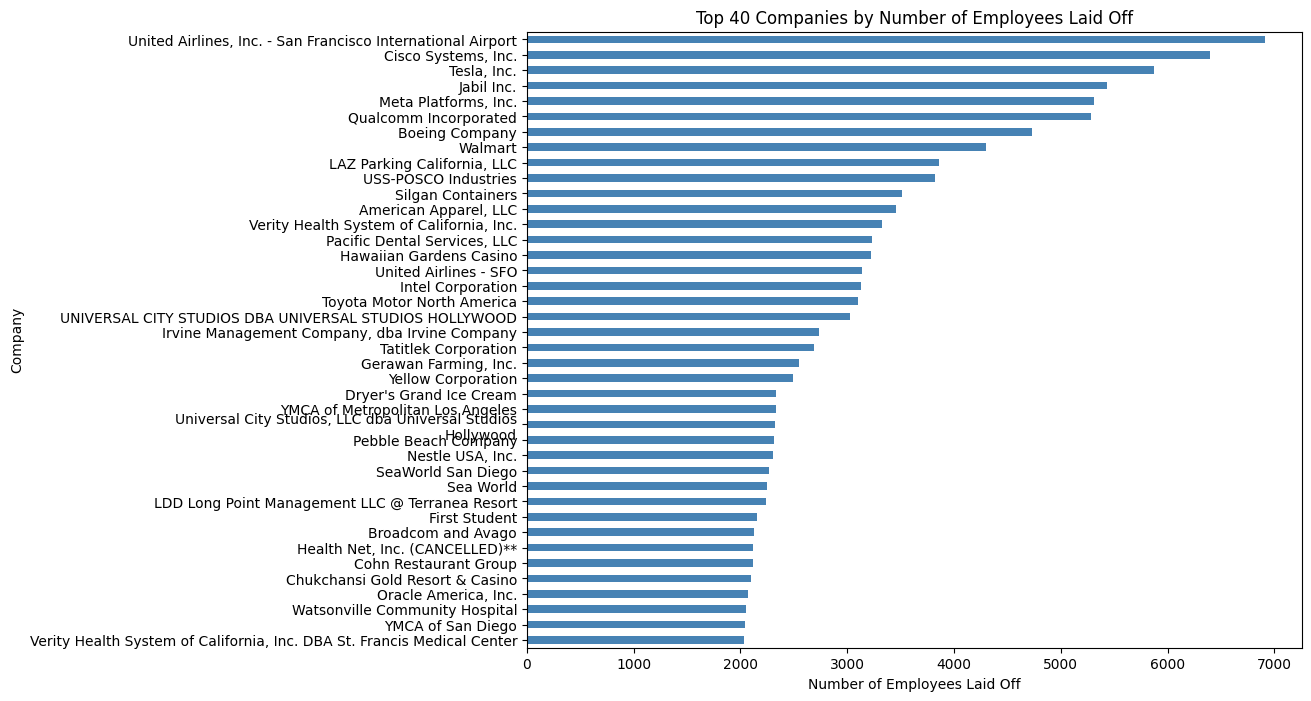

In [28]:
# Sum of employees laid off per company
company_layoffs = df.groupby('Company')['NoOfEmployees'].sum().sort_values(ascending=False)

# Select the top 10 companies
top_companies = company_layoffs.head(40)

# Plotting the data
plt.figure(figsize=(10, 8))
top_companies.plot(kind='barh', color='steelblue')
plt.title('Top 40 Companies by Number of Employees Laid Off')
plt.xlabel('Number of Employees Laid Off')
plt.ylabel('Company')
plt.gca().invert_yaxis()  # Invert y-axis to have the company with the most layoffs at the top
plt.show()

In [29]:
# Impact Analysis: Examining sectors or job types most impacted based on company and number of employees affected

# Convert 'NoOfEmployees' to numerical values for aggregation
df['NoOfEmployees'] = pd.to_numeric(df['NoOfEmployees'], errors='coerce')

# Grouping by company to get the average and total number of employees affected, and the distinct notice dates
company_impact = df.groupby('Company').agg(
    NoticeCount=pd.NamedAgg(column='Address', aggfunc='count'),
    CountiesCount=pd.NamedAgg(column='County', aggfunc='nunique'),
    LocationsCount=pd.NamedAgg(column='Address', aggfunc='nunique'),
    FirstNoticeDate=pd.NamedAgg(column='NoticeDate', aggfunc='min'),
    LastNoticeDate=pd.NamedAgg(column='NoticeDate', aggfunc='max'),
    MinEmployeesAffected=pd.NamedAgg(column='NoOfEmployees', aggfunc='min'),
    MaxEmployeesAffected=pd.NamedAgg(column='NoOfEmployees', aggfunc='max'),
    AverageEmployeesAffected=pd.NamedAgg(column='NoOfEmployees', aggfunc='mean'),
    TotalEmployeesAffected=pd.NamedAgg(column='NoOfEmployees', aggfunc='sum'),
).sort_values(by='TotalEmployeesAffected', ascending=False).head(10)

total_employees_affected=company_impact['TotalEmployeesAffected'].sum()
company_impact['PercentageOfTotal'] = (company_impact['TotalEmployeesAffected'] / total_employees_affected) * 100
columns_to_round = ['TotalEmployeesAffected', 'AverageEmployeesAffected', 'NoticeCount', 'PercentageOfTotal']
company_impact[columns_to_round] = company_impact[columns_to_round].round(0)

# Displaying the top 10 companies with the most employees affected
company_impact.reset_index()

,Company,NoticeCount,CountiesCount,LocationsCount,FirstNoticeDate,LastNoticeDate,MinEmployeesAffected,MaxEmployeesAffected,AverageEmployeesAffected,TotalEmployeesAffected,PercentageOfTotal
0,"United Airlines, Inc. - San Francisco Internat...",0,1,0,2020-07-08,2020-07-08,6912,6912,6912.0,6912,13.0
1,"Cisco Systems, Inc.",8,3,4,2014-09-22,2024-02-15,9,1005,229.0,6399,12.0
2,"Tesla, Inc.",38,8,31,2017-08-29,2024-05-13,1,1452,133.0,5869,11.0
3,Jabil Inc.,20,7,12,2018-09-21,2024-03-27,9,562,181.0,5434,10.0
4,"Meta Platforms, Inc.",94,6,88,2022-11-11,2023-05-29,1,632,56.0,5308,10.0
5,Qualcomm Incorporated,34,3,28,2014-12-10,2023-10-11,1,1314,112.0,5284,10.0
6,Boeing Company,2,2,2,2014-07-18,2023-11-08,1,227,35.0,4726,9.0
7,Walmart,12,10,12,2016-01-15,2024-05-17,7,953,172.0,4296,8.0
8,"LAZ Parking California, LLC",0,1,0,2020-03-30,2020-12-22,657,2260,1287.0,3860,7.0
9,USS-POSCO Industries,0,1,0,2014-08-25,2019-09-12,575,666,637.0,3823,7.0


##### Interactive Visualizations

In [30]:
def create_interactive_line_chart(df, date_column, title='Trend Over Time', width=800, height=400):
    """
    Generates an interactive line chart of counts over time using Altair.

    Parameters:
    - df: pandas DataFrame containing the data.
    - date_column: string, the name of the column in df that contains date information.
    - title: string, the title of the chart.
    - width: int, the width of the chart.
    - height: int, the height of the chart.

    Returns:
    - An Altair Chart object.
    """
    # Ensure the date column is in datetime format
    df[date_column] = pd.to_datetime(df[date_column])

    # Create a new column for month-year to aggregate data by month
    df['MonthYear'] = df[date_column].dt.to_period('M')

    # Aggregate data to count entries by month
    monthly_data = df.groupby('MonthYear').size().reset_index(name='Notices')

    # Convert 'MonthYear' to string for Altair
    monthly_data['MonthYear'] = monthly_data['MonthYear'].astype(str)

    # Create an interactive line chart
    chart = alt.Chart(monthly_data).mark_line().encode(
        x=alt.X('MonthYear:T', title='Month and Year'),
        y=alt.Y('Notices:Q', title='Number of Notices'),
        tooltip=['MonthYear:T', 'Notices:Q']
    ).properties(
        title=alt.TitleParams(text=title, fontSize=18),  # Customize title font size
        width=width,
        height=height
    ).interactive()

    return chart


def create_bar_chart(df, type_column, title='Distribution of Types', width=800, height=400):
    """
    Generates a bar chart showing the distribution of types using Altair.

    Parameters:
    - df: pandas DataFrame containing the data.
    - type_column: string, the name of the column in df that contains the type information.
    - title: string, the title of the chart.
    - width: int, the width of the chart.
    - height: int, the height of the chart.

    Returns:
    - An Altair Chart object.
    """
    # Prepare the data: count the occurrences of each type
    type_counts = df[type_column].value_counts().reset_index()
    type_counts.columns = ['Type', 'Count']

    # Generate a bar chart
    chart = alt.Chart(type_counts).mark_bar().encode(
        x=alt.X('Type:N', sort='-y', title='Type', axis=alt.Axis(labelAngle=0)),  # Set label angle to 0 for horizontal labels
        y=alt.Y('Count:Q', title='Count'),
        color='Type:N',
        tooltip=['Type:N', 'Count:Q']
    ).properties(
        title=alt.TitleParams(text=title, fontSize=18),  # Customize title font size
        width=width,
        height=height
    )

    # Add text on top of each bar
    text = chart.mark_text(
        align='center',
        baseline='bottom',
        dy=-5  # Adjusts the text position above the bar
    ).encode(
        text='Count:Q'
    )

    # Layer the text marks on top of the bar chart
    chart = alt.layer(chart, text)

    return chart


def create_pie_chart(df, column_name, title='Pie Chart', width=800, height=400):
    """
    Creates a pie chart to visualize the distribution of categories in a specified column,
    including a legend and customizable dimensions.

    Parameters:
    - df: pandas DataFrame containing the data.
    - column_name: str, the name of the column to visualize.
    - chart_title: str, the title of the chart.
    - width: int, the width of the chart (default 400).
    - height: int, the height of the chart (default 400).

    Returns:
    - An Altair Chart object.
    """
    # Aggregate the data to count each category
    type_counts = df[column_name].value_counts().reset_index()
    type_counts.columns = ['Category', 'Counts']
    # Calculate the percentage of each category
    type_counts['Percentage'] = (type_counts['Counts'] / type_counts['Counts'].sum()) * 100

    # Create the pie chart
    pie_chart = alt.Chart(type_counts, width=width, height=height).mark_arc().encode(
        theta=alt.Theta(field="Percentage", type="quantitative", stack=True),
        color=alt.Color(field="Category", type="nominal", legend=alt.Legend(title="Categories")),
        tooltip=[alt.Tooltip('Category:N'), alt.Tooltip('Percentage:Q', format='.2f')]
    ).properties(
        title=alt.TitleParams(text=title, fontSize=18),  # Customize title font size
    )

    chart = pie_chart.mark_arc(outerRadius=160)

    return chart


def create_top_layoffs_chart_by_county(df):
    """
    Generates a bar chart showing the top 10 counties with the highest number of affected employees.

    Parameters:
    - df: pandas DataFrame, the dataset containing layoff information with columns
          'County/Parish' and 'No. Of Employees'.

    Returns:
    - An Altair Chart object.
    """
    # Aggregate layoffs by county and sum the number of employees affected
    layoff_data = df.groupby('County')['NoOfEmployees'].sum().reset_index()

    # Sort the data and select the top 10 counties
    top_counties = layoff_data.sort_values(by='NoOfEmployees', ascending=False).head(15)

    # Create the bar chart with counties on the x-axis and counts on the y-axis
    chart = alt.Chart(top_counties).mark_bar().encode(
        y=alt.Y('NoOfEmployees:Q', title='Number of Affected Employees'),
        x=alt.X('County:N', sort='-y', title='County'),
        tooltip=[alt.Tooltip('County:N', title="County"), alt.Tooltip('NoOfEmployees:Q', title="Number of Affected Employees")]
    ).properties(
        title='Top 10 Counties by Number of Affected Employees',
        width=800,
        height=400
    ).configure_axis(
        labelFontSize=12,
        titleFontSize=14
    )

    return chart

In [31]:
chart = create_interactive_line_chart(df=df, date_column='NoticeDate', title='California WARN Notices Over Time')
chart.display()

alt.Chart(...)

In [32]:
# Example usage:
bar_chart = create_bar_chart(df=df, type_column='LayoffClosureType', title='Distribution of Layoff/Closure Types')
bar_chart

alt.LayerChart(...)

In [33]:
pie_chart = create_pie_chart(df, column_name='LayoffClosureType', title='Distribution of Layoff/Closure Types')
pie_chart

alt.Chart(...)

In [34]:
chart = create_top_layoffs_chart_by_county(df)
chart

alt.Chart(...)

## Recap of What We've Covered

**Data Processing**

Throughout this notebook, we've performed a series of data processing steps to ensure our analysis is built on a solid foundation:

1. We started by reading a CSV file into a pandas DataFrame.
2. We cleaned the column headers, removing newline characters, periods, spaces, and slashes.
3. We extracted ZIP and state codes from an 'Address' column, creating new columns 'PostalCode' and 'StateCode' respectively.
4. We converted 'NoticeDate', 'ProcessedDate', and 'EffectiveDate' into datetime objects formatted as YYYY-MM-DD.
5. We sorted the DataFrame by 'NoticeDate' in descending order to prepare for chronological analysis.

**Data Analysis**

Our analysis delved deep into the dataset, uncovering various facets of the WARN data:

- We provided descriptive statistics on numerical columns such as 'NoOfEmployees' and summarized categorical data like 'Company' and 'LayoffClosure'.
- We analyzed the date range covered by notice and processed dates, and looked at the geographical distribution of layoffs across different states and ZIP codes.
- We evaluated the frequency of different types of layoffs and closures, identified companies with frequent layoff notices, and examined trends over time.
- Our geographical and temporal trend analyses highlighted how layoffs and closures are distributed and evolving across California.
- In our impact analysis, we assessed which sectors or job types were most affected, looking at the companies and the number of employees laid off.

**Data Visualization**

To visually articulate our findings, we created several plots:

- Trends in layoffs per month.
- Distribution of types of layoffs and closures.
- Companies and counties with the highest number of layoffs.
- Maps and charts showcasing the geographic spread of layoffs within California, including top and bottom ZIP codes.

**Whats next?**
- TBD



## Connect with Me
For more insights, discussions, or collaborations on data analysis and visualization, feel free to connect with me on [LinkedIn]("https://www.linkedin.com/in/ericttran3/").
